In [7]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


class AutoSegmentImage:
    def __init__(self, img_path: str | Path):
        self.image = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        self.masks = None

    def plot_image(self):
        plt.imshow(self.image)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def get_masks(self, **kwargs):
        from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

        sam_checkpoint = "./model/sam_vit_h_4b8939.pth"
        model_type = "default"

        device = "cuda"

        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=device)

        mask_generator = SamAutomaticMaskGenerator(model=sam, **kwargs)
        self.masks = mask_generator.generate(self.image)
        return mask_generator.generate(self.image)

    def plot_masks(self):
        def show_segments(segments):
            if len(segments) == 0:
                return
            sorted_anns = sorted(segments, key=(lambda x: x['area']), reverse=True)
            ax = plt.gca()
            ax.set_autoscale_on(False)
            for ann in tqdm(sorted_anns):
                m = ann['segmentation']
                img = np.ones((m.shape[0], m.shape[1], 3))
                color_mask = np.random.random((1, 3)).tolist()[0]
                for i in range(3):
                    img[:, :, i] = color_mask[i]
                ax.imshow(np.dstack((img, m * 0.35)))

        masks = self.get_masks()
        plt.imshow(self.image)
        show_segments(masks)
        plt.axis('off')

        plt.tight_layout()
        plt.show()


Demo picture: https://unsplash.com/photos/6KLyD-cUFhc

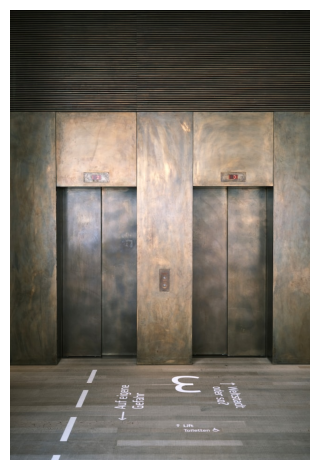

100%|██████████| 32/32 [00:00<00:00, 35.24it/s]


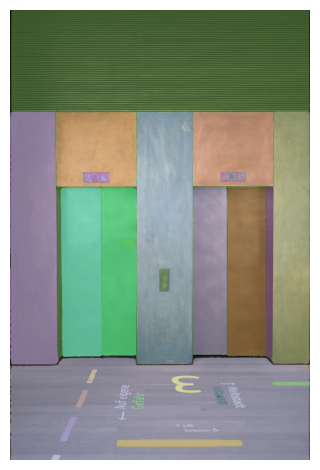

In [8]:
img = AutoSegmentImage(Path("./data/demo.jpg"))
img.plot_image()
img.plot_masks()

In [9]:
np.where(img.masks[1]['segmentation'])

(array([378, 378, 378, ..., 735, 735, 735], dtype=int64),
 array([401, 402, 403, ..., 416, 428, 429], dtype=int64))

In [10]:
img.masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False,  True, ...,  True, False, False],
         [False, False,  True, ...,  True, False, False],
         [False, False,  True, ...,  True, False, False]]),
  'area': 133656,
  'bbox': [0, 741, 638, 218],
  'predicted_iou': 1.0353500843048096,
  'point_coords': [[470.0, 825.0]],
  'stability_score': 0.9819062352180481,
  'crop_box': [0, 0, 640, 960]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 26052,
  'bbox': [390, 378, 73, 3